<a href="https://colab.research.google.com/github/alefram/notebooks/blob/master/img_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pokedex using CNN

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [2]:

# import libraries

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

import numpy as np
import pathlib
import PIL
import PIL.Image
import datetime

from datasets import load_dataset

## Data setup

In [3]:
ds = load_dataset("fcakyon/pokemon-classification", name="full")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/4869 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1390 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/732 [00:00<?, ? examples/s]

In [4]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = ds['train']
test_ds = ds['test']
val_ds =  ds['validation']

class_names = train_ds.features['labels'].names

#convert to tensorflow dataset for use with fit
train_ds = train_ds.to_tf_dataset(
    columns = ['image'],
    label_cols = ['labels'],
    batch_size = batch_size,
    shuffle = True
)

val_ds = val_ds.to_tf_dataset(
    columns = ['image'],
    label_cols = ['labels'],
    batch_size = batch_size,
    shuffle = True
)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:410: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


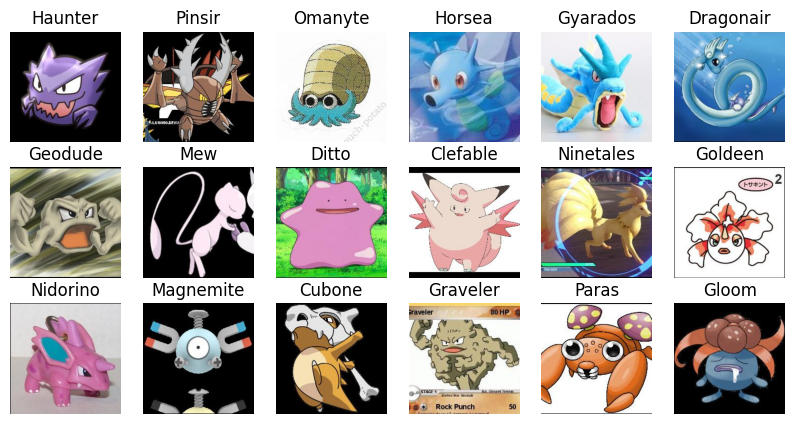

In [5]:
# visualize pokemons
plt.figure(figsize=(10, 5))
for images, labels in train_ds.take(1):
    for i in range(18):
        ax = plt.subplot(3, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
# normalized data 1 method
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.94117653


In [7]:
# improve the performance of the data
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Training

In [8]:
# Creating the model

num_classes = len(class_names)

# method 1
model = Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [9]:
# defining the loss function, the optimizer, and the metrics for the model (compile de model)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

In [61]:
# training
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)

Epoch 1/10
153/153 [==============================] - 6s 39ms/step - loss: 0.2623 - accuracy: 0.9252 - val_loss: 34.9067 - val_accuracy: 0.0158
Epoch 2/10
153/153 [==============================] - 6s 38ms/step - loss: 0.1451 - accuracy: 0.9634 - val_loss: 38.4709 - val_accuracy: 0.0173
Epoch 3/10
153/153 [==============================] - 6s 37ms/step - loss: 0.0973 - accuracy: 0.9735 - val_loss: 39.1563 - val_accuracy: 0.0144
Epoch 4/10
153/153 [==============================] - 6s 38ms/step - loss: 0.0663 - accuracy: 0.9827 - val_loss: 45.9650 - val_accuracy: 0.0187
Epoch 5/10
153/153 [==============================] - 6s 38ms/step - loss: 0.0615 - accuracy: 0.9850 - val_loss: 43.2594 - val_accuracy: 0.0180
Epoch 6/10
153/153 [==============================] - 6s 38ms/step - loss: 0.0356 - accuracy: 0.9912 - val_loss: 45.6457 - val_accuracy: 0.0158
Epoch 7/10
153/153 [==============================] - 6s 39ms/step - loss: 0.0201 - accuracy: 0.9969 - val_loss: 45.3868 - val_accuracy:

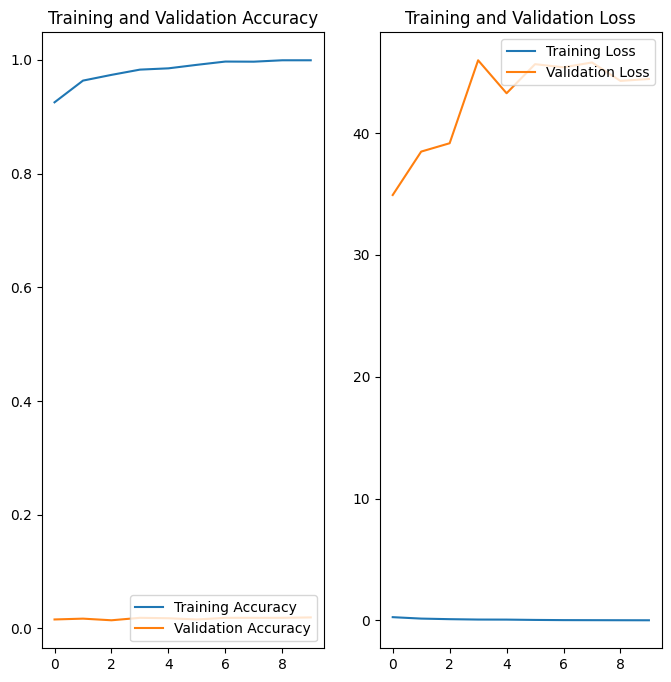

In [62]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Snorlax
66


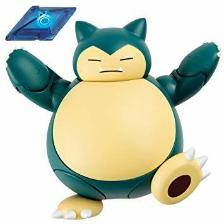

In [102]:
n = 475
image = test_ds['image'][n]
label =  test_ds['labels'][n]
print(class_names[label])
print(label)
image

In [103]:
img_array = tf.keras.utils.img_to_array(test_ds['image'][n])
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 19ms/step
This image most likely belongs to Dragonite with a 70.86 percent confidence.
